In [12]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from particles import resampling as rs
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from scipy.special import logsumexp
from scipy.spatial.distance import cdist
import time
import importlib
import sys
sys.path.append('..')

import GaussianODEs as ode
importlib.reload(ode)

<module 'GaussianODEs' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Gaussian/../GaussianODEs.py'>

In [2]:
d = 1

In [3]:
ms = 1*np.ones(d)
Sigmas = 5*np.eye(d)
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

In [4]:
Sigmas_inv = linalg.inv(Sigmas)

In [15]:
def logpi_MultiGaussian(x, ms, Sigmas_inv):
    
    # Compute (x - m)
    xm = x - ms

    quad = np.sum(xm @ Sigmas_inv * xm, axis=1)
    
    return -0.5*quad

def SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, nmcmc):
    d = ms.size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    W = np.zeros((Niter, N))
    X[0, :] = X0.T
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        if(nmcmc > 1):
            Xmcmc = np.zeros((nmcmc, d, N))
            Xmcmc[0, :] = X[n-1, :, :]
            for j in range(1, nmcmc):
                gradient_step = Xmcmc[j-1, :] - gamma*np.matmul(Sigmas_inv, (Xmcmc[j-1, :].T-ms).T)
                Xmcmc[j, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
            X[n, :] = Xmcmc[nmcmc-1, :]
        else:
            gradient_step = X[n-1, :, :] - gamma*np.matmul(Sigmas_inv, (X[n-1, :, :].T-ms).T)
            X[n, :, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
        distSq = -(1.0 / (4 * gamma))*cdist(X[n, :, :].T, gradient_step.T, metric='sqeuclidean')
        weight_denominator = logsumexp(distSq, axis=1)
        logW = (1-np.exp(-gamma))*(logpi_MultiGaussian(X[n, :, :].T, ms, Sigmas_inv)-weight_denominator)
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W

def SMC_UnitFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, nmcmc):
    d = ms.size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    X[0,:,:] = X0.T
    W = np.zeros((Niter, N))
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        t = gamma*n
        tpast = gamma*(n-1)
        l = 1-np.exp(-t)
        lpast = 1-np.exp(-tpast)
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        if(nmcmc > 1):
            Xmcmc = np.zeros((nmcmc, d, N))
            Xmcmc[0, :] = X[n-1, :, :]
            for j in range(1, nmcmc):
                prop = rwm_proposal(Xmcmc[j-1, :].T, W[n-1, :]).T
                Xmcmc[j, :] = rwm_accept_reject(prop, Xmcmc[j-1, :], ms, Sigmas, l)
            X[n, :] = Xmcmc[nmcmc-1, :]
        else:
            prop = rwm_proposal(X[n-1, :, :].T, W[n-1, :]).T
            X[n, :] = rwm_accept_reject(prop, X[n-1, :, :], ms, Sigmas, l)
        # reweight
        delta = l - lpast
        logW = delta*(0.5*np.sum(X[n, :, :]**2, axis = 0) + logpi_MultiGaussian(X[n, :, :].T, ms, Sigmas_inv))
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W


def view_2d_array(theta):
    """Returns a view to record array theta which behaves
    like a (N,d) float array.
    """
    v = theta.view(float)
    N = theta.shape[0]
    v.shape = (N, -1)
    # raise an error if v cannot be reshaped without creating a copy
    return v
def rwm_proposal(v, W):
    arr = view_2d_array(v)
    N, d = arr.shape
    m, cov = rs.wmean_and_cov(W, arr)
    scale = 2.38 / np.sqrt(d)
    L = scale * linalg.cholesky(cov, lower=True)
    arr_prop = arr + stats.norm.rvs(size=arr.shape) @ L.T
    return arr_prop
def rwm_accept_reject(prop, v, ms, Sigmas, l):
    log_acceptance = (1-l)*0.5*np.sum(v**2 - prop**2, axis = 0) + l*(multivariate_normal.logpdf(prop.T, ms, Sigmas)-multivariate_normal.logpdf(v.T, ms, Sigmas))
    accepted = np.log(np.random.uniform(size = v.shape[1])) <= log_acceptance
    output = np.copy(v)
    output[:, accepted] = prop[:, accepted]
    return output

## WFR

In [7]:
Niter = 100
gamma = 0.01
mean_eq_wfr, var_eq_wfr, kl_wfrinf = ode.wfr_infinite_time(mu0, ms, Sigma0, Sigmas, Niter, gamma)

In [8]:
N = 1000
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)

In [16]:
x, W = SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, 1)

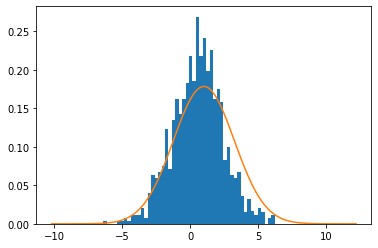

In [17]:
mu = ms[0]
sigma = Sigmas[0]

plt.hist(x[-1, 0, :], density = True, weights = W[-1, :], bins = 50)
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))

In [18]:
mean_smc = np.zeros(Niter)
var_smc = np.zeros(Niter)
kl_smc = np.zeros(Niter)
for i in range(Niter):
    mean_smc[i] = np.sum(x[i, 0, :]*W[i, :])
    var_smc[i] = np.sum(x[i, 0, :]**2*W[i, :]) - mean_smc[i]**2
    kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_26515/206939111.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)


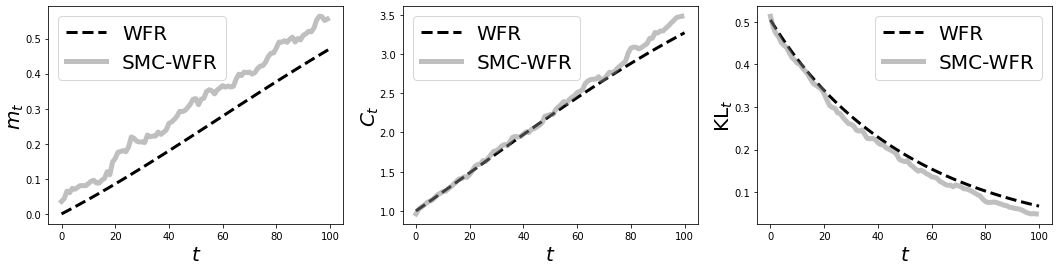

In [19]:
plt.figure(figsize = (18, 4))
plt.subplot(1, 3, 1)
plt.plot(mean_eq_wfr, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(mean_smc, label = 'SMC-WFR', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$m_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
plt.subplot(1, 3, 2)
plt.plot(var_eq_wfr, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(var_smc, label = 'SMC-WFR', color = 'gray', alpha = 0.5, lw = 5)
plt.legend(fontsize = 20)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$C_t$', fontsize = 20, labelpad=-1)
plt.subplot(1, 3, 3)
plt.plot(kl_wfrinf, label = 'WFR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(kl_smc, label = 'SMC-WFR', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
# plt.savefig('SMC_WFR_gaussian.pdf', bbox_inches="tight")

## Unit time FR

In [20]:
mean_eq_fr, var_eq_fr, kl_fr = ode.fisherrao_infinite_time(mu0, ms, Sigma0, Sigmas, Niter, gamma)

In [21]:
xSMC, WSMC = SMC_UnitFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, 1)

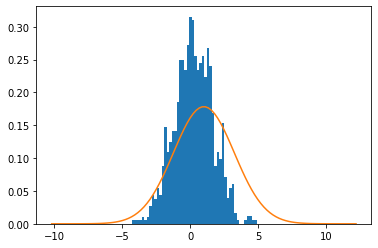

In [22]:
plt.hist(xSMC[-1, 0, :], density = True, weights = WSMC[-1, :], bins = 50)
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))

In [23]:
mean_smc = np.zeros(Niter)
var_smc = np.zeros(Niter)
kl_smc = np.zeros(Niter)
for i in range(Niter):
    mean_smc[i] = np.sum(xSMC[i, 0, :]*WSMC[i, :])
    var_smc[i] = np.sum(xSMC[i, 0, :]**2*WSMC[i, :]) - mean_smc[i]**2
    kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_26515/3773519912.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl_smc[i] = ode.KL(mean_smc[i], var_smc[i], mu, sigma)


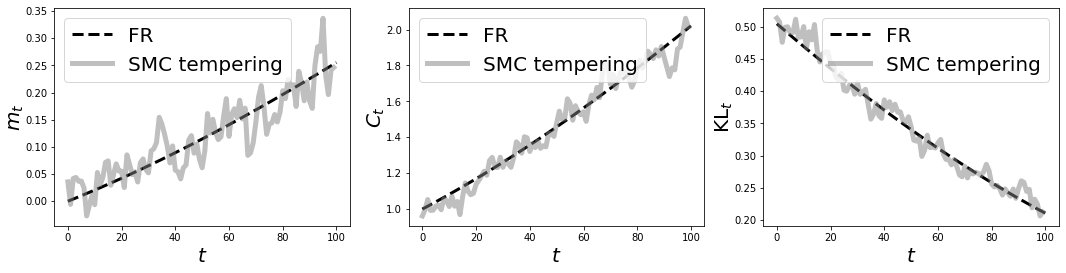

In [24]:
plt.figure(figsize = (18, 4))
plt.subplot(1, 3, 1)
plt.plot(mean_eq_fr, label = 'FR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(mean_smc, label = 'SMC tempering', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$m_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
plt.subplot(1, 3, 2)
plt.plot(var_eq_fr, label = 'FR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(var_smc, label = 'SMC tempering', color = 'gray', alpha = 0.5, lw = 5)
plt.legend(fontsize = 20)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$C_t$', fontsize = 20, labelpad=-1)
plt.subplot(1, 3, 3)
plt.plot(kl_fr, label = 'FR', linestyle = 'dashed', lw = 3, color = 'black')
plt.plot(kl_smc, label = 'SMC tempering', color = 'gray', alpha = 0.5, lw = 5)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
plt.legend(fontsize = 20)
# plt.savefig('SMC_FR_gaussian.pdf', bbox_inches="tight")